<a href="https://colab.research.google.com/github/soiqualang/colab/blob/master/GEE_LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://code.earthengine.google.com/5cc9c9902c7e7e71b6f52040b4014ed3

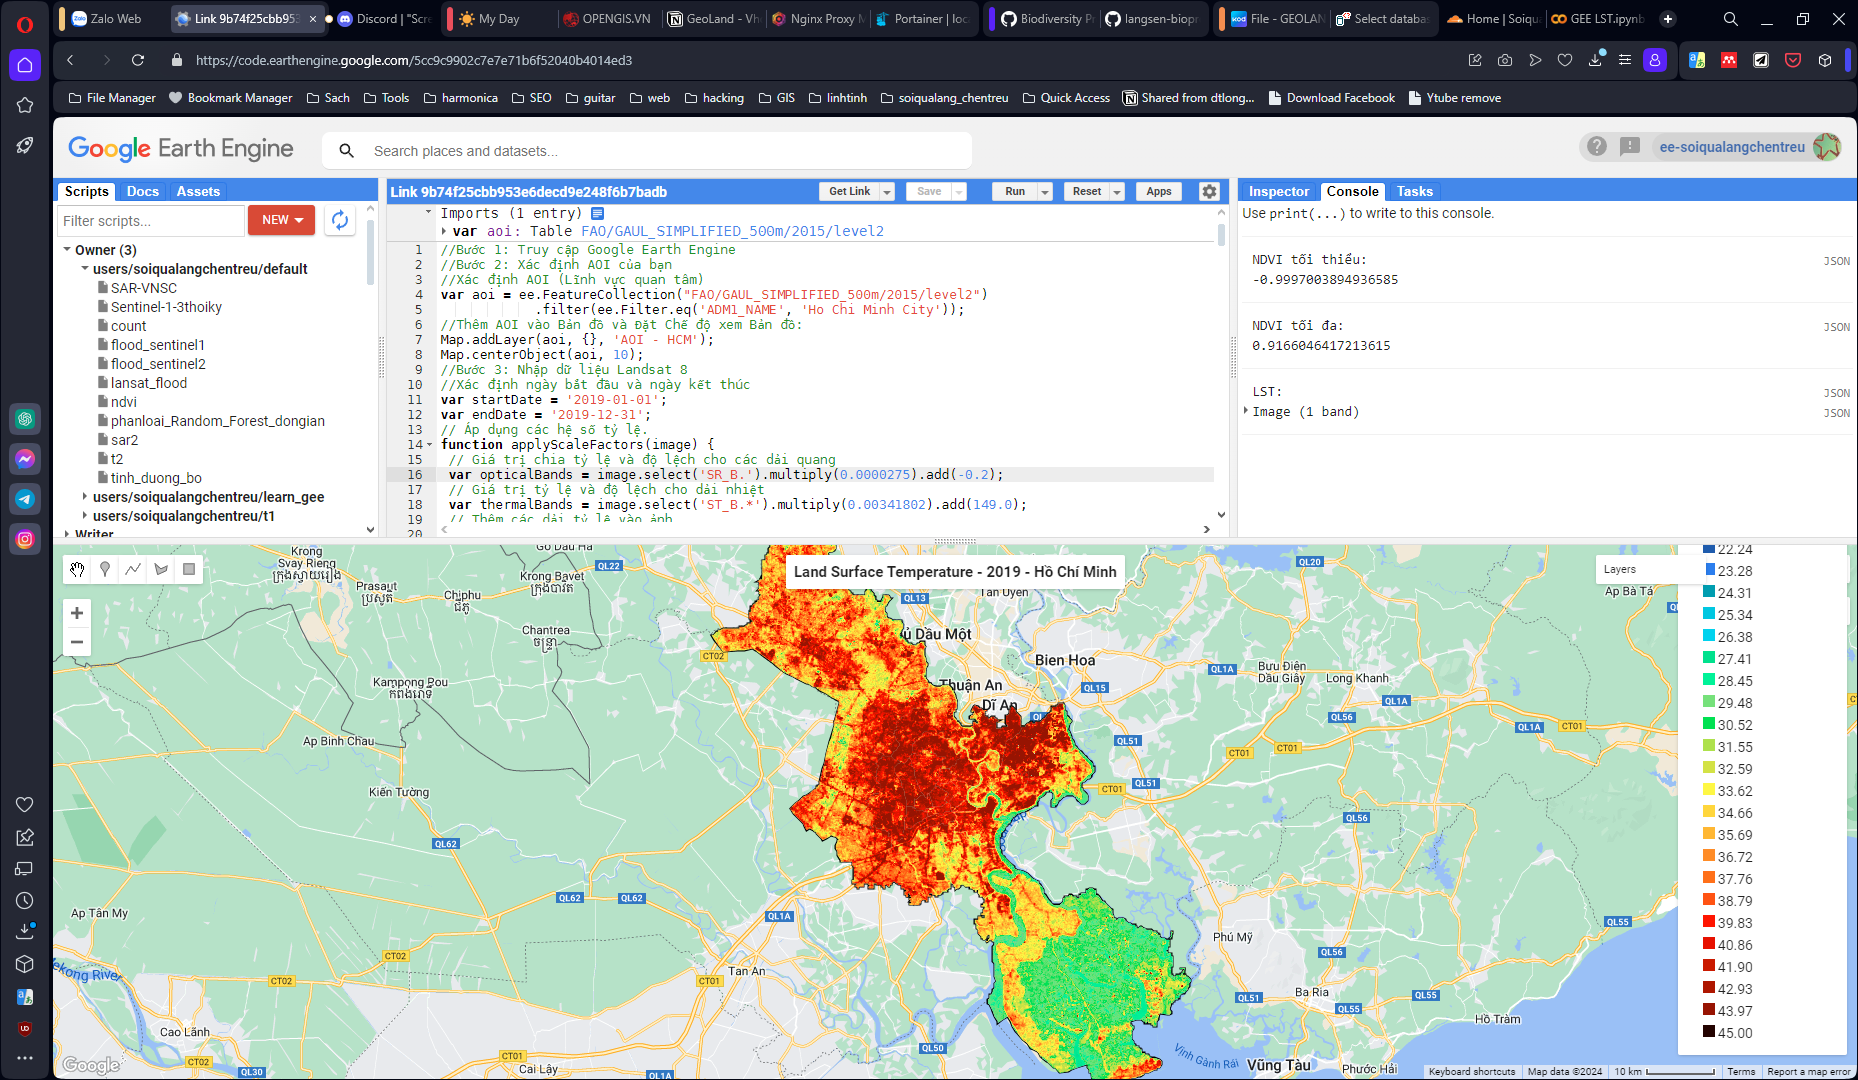

In [ ]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
import ee
import geemap

In [ ]:

m = geemap.Map()

#Bước 1: Truy cập Google Earth Engine
#Bước 2: Xác định AOI của bạn
#Xác định AOI (Lĩnh vực quan tâm)
aoi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2") \
            .filter(ee.Filter.eq('ADM1_NAME', 'Ho Chi Minh City'))
#Thêm AOI vào Bản đồ và Đặt Chế độ xem Bản đồ:
m.addLayer(aoi, {}, 'AOI - HCM')
m.centerObject(aoi, 10)
#Bước 3: Nhập dữ liệu Landsat 8
#Xác định ngày bắt đầu và ngày kết thúc
startDate = '2019-01-01'
endDate = '2019-12-31'
# Áp dụng các hệ số tỷ lệ.
def applyScaleFactors(image):
 # Giá trị chia tỷ lệ và độ lệch cho các dải quang
 opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
 # Giá trị tỷ lệ và độ lệch cho dải nhiệt
 thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
 # Thêm các dải tỷ lệ vào ảnh
 return image.addBands(opticalBands, None, True) \
 .addBands(thermalBands, None, True)

# Chức năng che các đám mây và bóng đám mây trong Landsat 8
def cloudMask(image):
  # Xác định bóng đám mây và mặt nạ bit đám mây (Bit 3 và 5)
  cloudShadowBitmask = (1 << 3)
  cloudBitmask = (1 << 5)
  # Chọn dải Đánh giá chất lượng (QA) cho thông tin chất lượng pixel
  qa = image.select('QA_PIXEL')
  # Tạo mặt nạ nhị phân để xác định các điều kiện rõ ràng (cả đám mây và bit bóng đám mây được đặt thành 0)
  mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0) \
                .And(qa.bitwiseAnd(cloudBitmask).eq(0))
  # Cập nhật hình ảnh gốc, che đi đám mây và các pixel bị ảnh hưởng bởi bóng của đám mây
  return image.updateMask(mask)

# Nhập và xử lý trước ảnh Landsat 8
image = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
              .filterBounds(aoi) \
              .filterDate(startDate, endDate) \
              .map(applyScaleFactors) \
              .map(cloudMask) \
              .median() \
              .clip(aoi)
# Xác định các tham số hiển thị cho hình ảnh True Color (dải 4, 3 và 2)
visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.15,
}
# Thêm hình ảnh đã xử lý vào bản đồ với
m.addLayer(image, visualization, 'True Color 432')
#Bước 4: Tính toán NDVI, Tỷ lệ thảm thực vật, Độ phát xạ
# Tính chỉ số thực vật chênh lệch chuẩn hóa (NDVI)
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
# Xác định các tham số trực quan hóa NDVI
ndviPalette = {
 'min': -1,
 'max': 1,
 'palette': ['blue', 'white', 'green']
}
m.addLayer(ndvi, ndviPalette, 'NDVI HCM')
#Tính giá trị NDVI tối thiểu và tối đa
# Tính giá trị NDVI tối thiểu trong AOI

ndvi_min_reduce = ndvi.reduceRegion(
        reducer   = ee.Reducer.min(),
        geometry  = aoi,
        scale     = 30,
        maxPixels = 1e9
    )

ndviMin = ee.Number(ndvi_min_reduce.values().get(0))

# Tính giá trị NDVI lớn nhất trong AOI

ndvi_max_reduce = ndvi.reduceRegion(
        reducer   = ee.Reducer.max(),
        geometry  = aoi,
        scale     = 30,
        maxPixels = 1e9
    )

ndviMax = ee.Number(ndvi_max_reduce.values().get(0))
# In giá trị NDVI tối thiểu và tối đa
# print ( "NDVI tối thiểu:" , ndviMin)
# print ( "NDVI tối đa:" , ndviMax)
#Tính toán tỷ lệ thảm thực vật (PV) và độ phát xạ (EM)
#Tỷ lệ thảm thực vật (PV) = (NDVI — NDVI_min) / (NDVI_max — NDVI_min)
# NDVI đại diện cho giá trị NDVI của pixel.
# NDVI_min là giá trị NDVI tối thiểu được chỉ định.
# NDVI_max là giá trị NDVI tối đa được chỉ định.#
# Tính toán Tỷ lệ thực vật (FV)
# Công thức: ((NDVI - NDVI_min) / (NDVI_max - NDVI_min))^2

# Tính Tỷ lệ thực vật (FV) bằng cách sử dụng các giá trị NDVI trong phạm vi đã chỉ định.
# NDVI_min đại diện cho giá trị NDVI tối thiểu và NDVI_max đại diện cho giá trị NDVI tối đa
fv = ((ndvi.subtract(ndviMin)).divide(ndviMax.subtract(ndviMin))) \
          .pow(ee.Number(2)) \
          .rename('FV')
# Tính toán độ phát xạ
# Công thức: 0,004 * FV + 0,986
# Tính toán độ phát xạ bề mặt đất (EM) bằng cách sử dụng Phân số thực vật (FV).
# Hệ số 0,004 biểu thị sự thay đổi độ phát xạ do thảm thực vật,
# và hệ số 0,986 biểu thị độ phát xạ cơ bản cho các bề mặt khác.
em = fv.multiply(ee.Number(0.004)).add(ee.Number(0.986)).rename('EM')
#Ước tính nhiệt độ bề mặt đất
# Chọn Thermal Band (Band 10) và Đổi tên
thermal = image.select('ST_B10').rename('thermal')
# Bây giờ, hãy tính nhiệt độ bề mặt đất (LST)
# Công thức: (TB / (1 + (λ * (TB / 1.438)) * ln(em))) - 273,15
lst = thermal.expression(
  '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', {
    'TB': thermal.select('thermal'), # Chọn dải nhiệt ( TB)
    'em': em # Gán độ phát xạ (em)
  }).rename('LST Ho Chi Minh 2019')
# print ( "LST:" , lst)
# Thêm lớp LST vào Bản đồ với Bản đồ tham số trực quan hóa tùy chỉnh
m.addLayer(lst, {
  'min': 18.47, # Giá trị LST tối thiểu
  'max': 42.86, # Giá trị LST tối đa
  'palette': [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ]}, 'Land Surface Temperature 2019')
#Tiêu đề và chú thích cho trực quan hóa LST
# Tạo chú giải cho trực quan hóa nhiệt độ bề mặt đất (LST)
minLST = 15; # Giá trị LST tối thiểu
maxLST = 45; # Giá trị LST tối đa
# Tạo bảng điều khiển cho chú giải với kiểu dáng
# legend = ui.Panel({
#   'style': {
#     'position': 'bottom-right',
#     'padding': '8px 15px',
#     'backgroundColor': 'white'
#   }
# })
# Tạo tiêu đề cho legend
# legendTitle = ui.Label({
#   'value': 'Land Surface Temperature (°C)',
#   'style': {
#     'fontWeight': 'bold',
#     'fontSize': '10px',
#     'margin': '0 0 8px 0',
#     'padding': '0'
#   }
# })
# Thêm tiêu đề chú giải vào chú
# legend.add(legendTitle)

# Xác định bảng màu cho Legend
palette = [
  '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
  '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
  '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
  'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
  'ff0000', 'de0101', 'c21301', 'a71001', '911003', '210300'
]
# Tính giá trị bước cho chú giải
# step = (maxLST - minLST) / (palette.length - 1)
# Vòng lặp qua bảng màu và tạo các mục chú giải
# for i in range(0, palette.length, 1):
#   # Tạo một hộp màu cho mỗi mục chú giải
#   colorBox = ui.Label({
#     'style': {
#       'backgroundColor': '#' + palette[i],
#       'padding': '6px',
#       'margin': '0 0 10px 10px',
#       'width': '10px'
#     }
#   })
# Tạo nhãn có giá trị LST cho mỗi mục chú giải
#   legendLabel = ui.Label({
#     'value': (minLST + i * step).toFixed(2),
#     'style': '{ margin': '0 0 5px 3px' }
#   })

  # Tạo bảng sắp xếp hộp màu và nhãn theo chiều ngang
#   legendPanel = ui.Panel({
#     'widgets': [colorBox, legendLabel],
#     'layout': ui.Panel.Layout.Flow('horizontal')
#   })

  # Thêm bảng chú giải vào chú
#    legend.add(legendPanel)

# Thêm chú giải vào bản đồ Google Earth Engine
#  m.add(legend)

# Tạo Tiêu đề bản đồ
# mapTitle = ui.Panel({
#   'style': {
#     'position': 'top-center',
#     'padding': '5px 5px'
#   }
# })
# mapTitle2 = ui.Label({
#   'value': 'Land Surface Temperature - 2019 - Hồ Chí Minh',
#   'style': {
#     'fontWeight': 'bold',
#     'fontSize': '15px',
#     'margin': '3px 3px 3px 3px',
#     'padding': '0'
#   }
# })
# mapTitle.add(mapTitle2)
# Thêm tiêu đề bản đồ vào bản đồ Google Earth Engine
# m.add(mapTitle)
m

AttributeError: module 'ee' has no attribute 'Reducer'

In [ ]:
pwd

'/content'

In [ ]:
import os
out_dir = '/content/'
out_file = os.path.join(out_dir, 'lst_hcm.tif')
hcm_region=aoi.geometry().bounds()
geemap.ee_export_image(lst, filename=out_file, scale=140,region=hcm_region)

Generating URL ...
Please wait ...
Data downloaded to /content/lst_hcm.tif
